In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import seaborn as sns
import matplotlib.pyplot as plt
import os
import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
df1=pd.read_csv('wine.xls')
df1.head()

,1,14.23,1.71,2.43,15.6,127,2.8,3.06,.28,2.29,5.64,1.04,3.92,1065
0,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       177 non-null    int64  
 1   14.23   177 non-null    float64
 2   1.71    177 non-null    float64
 3   2.43    177 non-null    float64
 4   15.6    177 non-null    float64
 5   127     177 non-null    int64  
 6   2.8     177 non-null    float64
 7   3.06    177 non-null    float64
 8   .28     177 non-null    float64
 9   2.29    177 non-null    float64
 10  5.64    177 non-null    float64
 11  1.04    177 non-null    float64
 12  3.92    177 non-null    float64
 13  1065    177 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.5 KB


In [4]:
df1.shape

(177, 14)

In [5]:
y=df1['1']
x=df1.drop('1',axis=1)

In [6]:
x.isnull().sum()

14.23    0
1.71     0
2.43     0
15.6     0
127      0
2.8      0
3.06     0
.28      0
2.29     0
5.64     0
1.04     0
3.92     0
1065     0
dtype: int64

In [7]:
y.value_counts()

2    71
1    58
3    48
Name: 1, dtype: int64

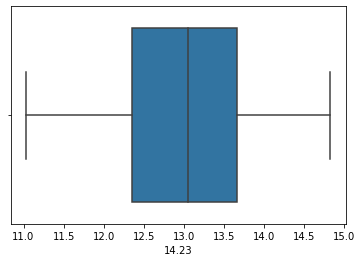

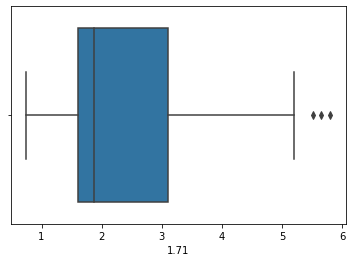

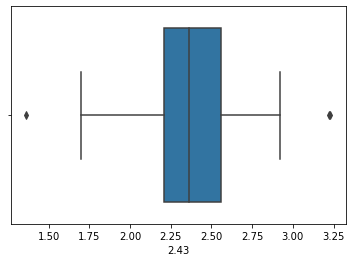

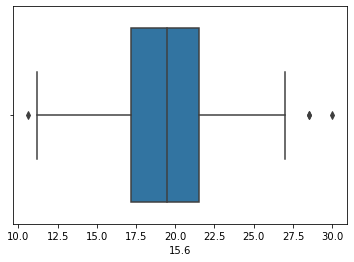

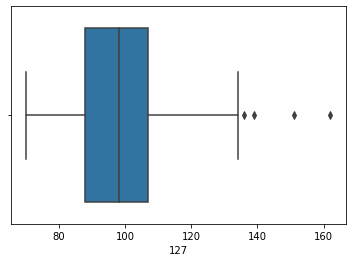

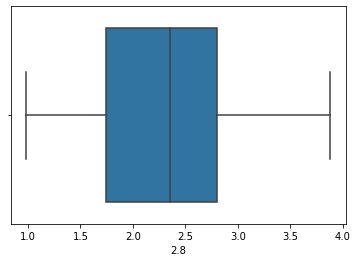

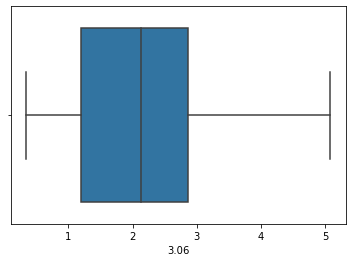

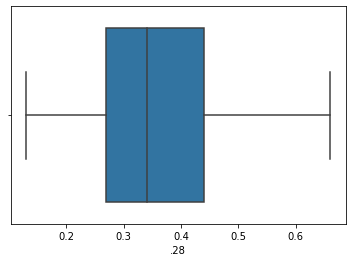

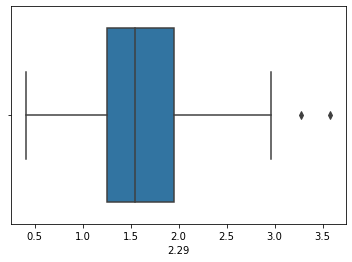

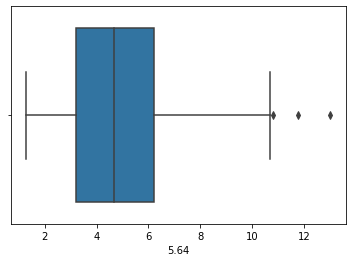

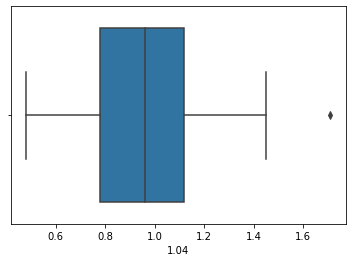

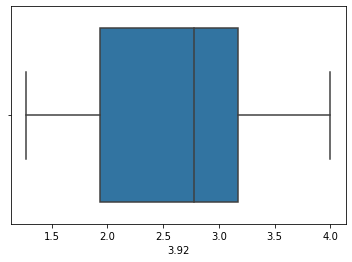

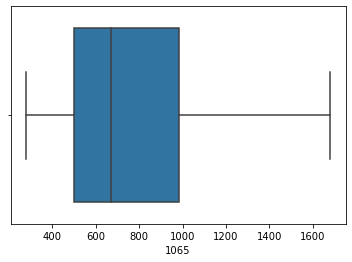

In [8]:
for i in x:
    sns.boxplot(x[i])
    plt.show()

Since there are not much outliers we are not going to treat the data.

# Aglomerative Hierarchical Clustering

In [9]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
xs = ss.fit_transform(x)

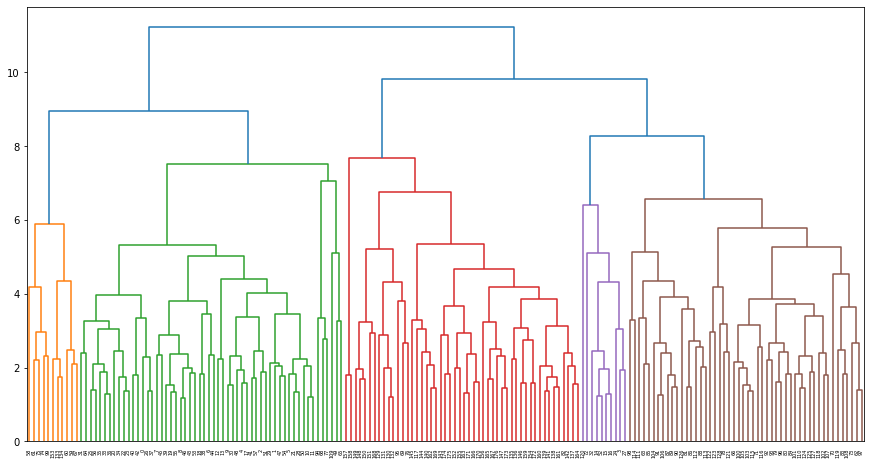

In [10]:
from scipy.cluster.hierarchy import dendrogram, cut_tree, linkage

plt.figure(figsize=(15,8))
mergings = linkage(xs,method='complete')
dendrogram(mergings)
plt.show()

In [11]:
cc = pd.Series(cut_tree(mergings,3).reshape(-1,))
cc.value_counts()

0    67
1    60
2    50
dtype: int64

In [12]:
df1['cluster']=cc

In [13]:
pd.crosstab(df1['1'],df1['cluster'])

cluster,0,1,2
1,,,
1,50,8,0
2,14,52,5
3,3,0,45


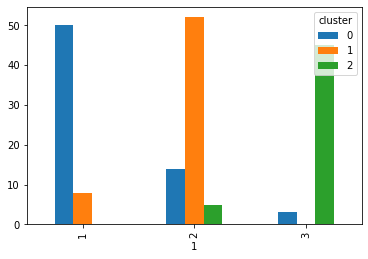

In [14]:
pd.crosstab(df1['1'],df1['cluster']).plot(kind='bar')
plt.show()

# K Means Clustering

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score as ss

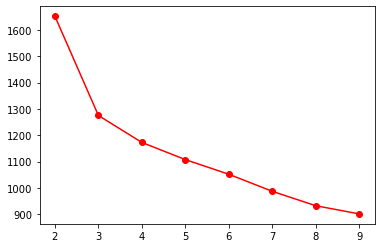

In [16]:
ssd=[]
ssc=[]
for k in range(2,10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(xs)
    ssd.append(kmeans.inertia_)
    labels=kmeans.labels_
    ssc.append(ss(xs,labels))
plt.plot(range(2,10),ssd,color='r',marker='o')
plt.show()
    
    

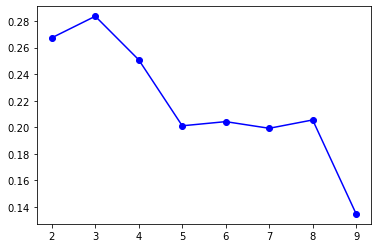

In [17]:
plt.plot(range(2,10),ssc,color='b',marker='o')
plt.show()

Here we find the best elbow bend at cluster number 3.So we will consider 3 clusters.

In [18]:
import plusmodules as pm

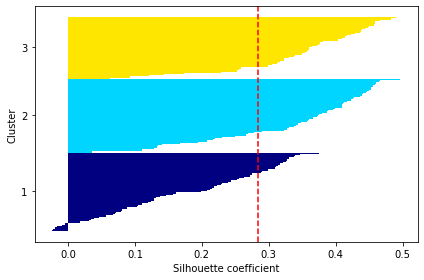

In [19]:
pm.svisualizer(xs,3)

In [20]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(xs)
labels = kmeans.labels_
df1['labels']=labels
pd.crosstab(df1['labels'],df1['1'])


1,1,2,3
labels,,,
0,0,65,0
1,0,3,48
2,58,3,0


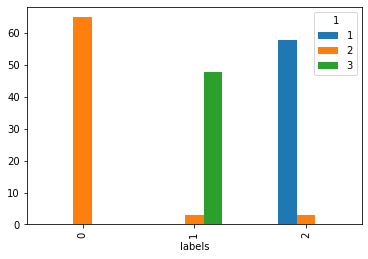

In [21]:
pd.crosstab(df1['labels'],df1['1']).plot(kind='bar')
plt.show()

# PCA Analysis

In [22]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(xs)

PCA()

In [23]:
pca.explained_variance_

array([4.7043776 , 2.51557865, 1.46158736, 0.92969665, 0.86663298,
       0.64851162, 0.55511807, 0.35273166, 0.29082309, 0.248211  ,
       0.2267211 , 0.16933351, 0.10454035])

In [24]:
np.cumsum(pca.explained_variance_ratio_)

array([0.35983071, 0.5522435 , 0.6640381 , 0.73514919, 0.80143663,
       0.8510403 , 0.89350044, 0.92048035, 0.94272497, 0.96171025,
       0.9790518 , 0.99200387, 1.        ])

Here we have 9 components below 95% variation so we will take PC1-PC9 and ignore PC10-PC13

In [25]:
pca = PCA(n_components=9)
pca.fit(xs)

PCA(n_components=9)

In [26]:
x_pca = pca.transform(xs)
x_pca.shape

(177, 9)

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [28]:
rfc=RandomForestClassifier()
params = {'n_estimators':randint(50,250),
          'max_features':randint(1,12),
       'max_depth':randint(1,10),
       'min_samples_leaf':randint(1,50)
                                    }

rsearch = RandomizedSearchCV(rfc,param_distributions=params,n_jobs=-1,return_train_score=True,cv=3)
rsearch.fit(x_pca,y)
rsearch.best_params_


{'max_depth': 4, 'max_features': 3, 'min_samples_leaf': 1, 'n_estimators': 171}

In [29]:
rfc= RandomForestClassifier(**rsearch.best_params_)
rfc.fit(x_pca,y)

RandomForestClassifier(max_depth=4, max_features=3, n_estimators=171)

In [30]:
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score

In [31]:
y_pred = rfc.predict(x_pca)
y_prob = rfc.predict_proba(x_pca)

print('Confusion Matrix:\n',confusion_matrix(y,y_pred))
print('\nAccuracy Score:',accuracy_score(y,y_pred))


Confusion Matrix:
 [[58  0  0]
 [ 0 71  0]
 [ 0  0 48]]

Accuracy Score: 1.0
